# Accomodation Price Prediction AirBnb - Boston Area

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from scipy.stats import skew, kurtosis

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Extraction

In [3]:
listings = pd.read_csv('listings_bst.csv')
reviews  = pd.read_csv('reviews_bst.csv')
calendar = pd.read_csv('calendar_bst.csv')

pd.set_option('display.max_columns', None)

In [4]:
listings.shape

(3585, 95)

### Check for missing data

In [5]:
#every column that has more than 30% of missing data, will be dropped
total = listings.isna().sum().sort_values(ascending=False)
percent = (listings.isna().sum()/len(listings)).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
neighbourhood_group_cleansed,3585,1.000000
jurisdiction_names,3585,1.000000
license,3585,1.000000
has_availability,3585,1.000000
square_feet,3529,0.984379
monthly_price,2697,0.752301
weekly_price,2693,0.751185
security_deposit,2243,0.625662
notes,1975,0.550907
interaction,1554,0.433473


In [6]:
missing_data = missing_data[missing_data['Percent'] > 0.31]
drop_col = list(missing_data.index)
len(drop_col)

15

In [7]:
def dropCol(col, df):
    df.drop(columns = col, axis=1, inplace=True)

dropCol(drop_col, listings)

In [8]:
listings.shape

(3585, 80)

### Check for useless columns to drop manually

In [9]:
useless_col = ['id','scrape_id', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url'
              , 'host_thumbnail_url', 'host_picture_url', 'country_code']

In [10]:
dropCol(useless_col, listings)

In [11]:
listings.shape

(3585, 68)

### Change data types from objects to integer

In [12]:
int_col = ['cleaning_fee', 'extra_people', 'host_response_rate', 'host_acceptance_rate']
    
for col in int_col:
    listings[col] = listings[col].str.extract(r'(\d+)')
    listings[col] = pd.to_numeric(listings[col], errors='coerce')

In [13]:
day_price = listings['price'] 
day_price = day_price.apply(lambda x: x.split('.')[0]).apply(lambda x: x.split('$')[-1]) #remove $ sign and cents
day_price = day_price.str.replace(',', '')
day_price = pd.to_numeric(day_price, errors='coerce') #convert the price(object datatype) to an integer
listings['price'] = day_price

In [14]:
#extract the amenities information in the accomodation, check for the number of features/amenities
listings['n_amenities'] = listings['amenities'].apply(lambda x: len(x.replace('{', '').replace('}', '').replace('"', '').split(',')))
listings.drop('amenities', axis=1, inplace=True) #Since we created a column with a number of amenities, we can drop the original column

# EDA

In [15]:
listings.describe()
#Here we can see that neither the cleaning fee nor the prices of the accomodations are calculated - seems to be an datatype error

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,n_amenities
count,3114.000000,3114.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3571.000000,3575.000000,3576.000000,3585.000000,2478.000000,3585.000000,3585.000000,3585.000000,3.585000e+03,3585.00000,3585.000000,3585.000000,3585.000000,3585.000000,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,3585.000000,2829.000000,3585.000000
mean,94.989082,84.173089,58.902371,58.902371,42.340032,-71.084818,3.041283,1.221647,1.255944,1.609060,173.925802,68.380145,1.429847,10.886192,3.171269,2.872584e+04,8.64993,21.833194,38.558159,179.346444,19.044630,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,12.733891,1.970908,15.862762
std,12.517686,21.779254,171.119663,171.119663,0.024403,0.031565,1.778929,0.501487,0.753060,1.011745,148.331321,51.297835,1.056787,19.137773,8.874133,1.670136e+06,10.43533,21.860966,33.158272,142.136180,35.571658,9.531686,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,29.415076,2.120561,4.832590
min,0.000000,0.000000,0.000000,0.000000,42.235942,-71.171789,1.000000,0.000000,0.000000,0.000000,10.000000,5.000000,0.000000,0.000000,1.000000,1.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000,1.000000
25%,97.000000,71.000000,1.000000,1.000000,42.329995,-71.105083,2.000000,1.000000,1.000000,1.000000,85.000000,25.000000,1.000000,0.000000,1.000000,3.650000e+02,0.00000,0.000000,0.000000,19.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.480000,13.000000
50%,100.000000,94.000000,2.000000,2.000000,42.345201,-71.078429,2.000000,1.000000,1.000000,1.000000,150.000000,50.000000,1.000000,0.000000,2.000000,1.125000e+03,4.00000,16.000000,37.000000,179.000000,5.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.170000,16.000000
75%,100.000000,100.000000,7.000000,7.000000,42.354685,-71.062155,4.000000,1.000000,2.000000,2.000000,220.000000,100.000000,1.000000,20.000000,3.000000,1.125000e+03,15.00000,40.000000,68.000000,325.000000,21.000000,98.250000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.720000,19.000000
max,100.000000,100.000000,749.000000,749.000000,42.389982,-71.000100,16.000000,6.000000,5.000000,16.000000,4000.000000,300.000000,14.000000,200.000000,300.000000,1.000000e+08,30.00000,60.000000,90.000000,365.000000,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000,31.000000


<AxesSubplot:xlabel='price', ylabel='Density'>

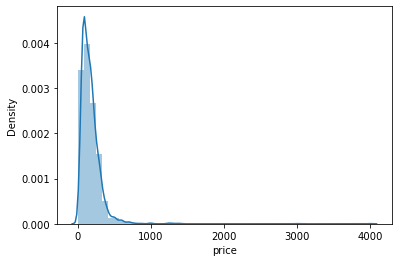

In [16]:
#Check distribution of accomodation price
sns.distplot(listings['price'])

In [17]:
#check the skewness and kurtosis
print('skewness of a normal symmetric distribution should be 0 - compared to ours: {}'.format(skew(listings['price'])))
print('excess kurtosis of a normal symmetric distribution should be 0 - compared to ours: {}'.format(kurtosis(listings['price'])))

skewness of a normal symmetric distribution should be 0 - compared to ours: 8.517917676910463
excess kurtosis of a normal symmetric distribution should be 0 - compared to ours: 168.11532221213594


In [18]:
#as well as our variance
print(np.var(listings['price'])) #Price fluctuates so widely

21996.04358809458


In [19]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      3585 non-null   object 
 1   name                              3585 non-null   object 
 2   summary                           3442 non-null   object 
 3   space                             2528 non-null   object 
 4   description                       3585 non-null   object 
 5   experiences_offered               3585 non-null   object 
 6   host_name                         3585 non-null   object 
 7   host_since                        3585 non-null   object 
 8   host_location                     3574 non-null   object 
 9   host_response_time                3114 non-null   object 
 10  host_response_rate                3114 non-null   float64
 11  host_acceptance_rate              3114 non-null   float64
 12  host_i

In [20]:
#see correlation on numeric features
numeric_features = listings.dtypes[listings.dtypes != 'object'].index

In [21]:
numeric_features

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month', 'n_amenities'],
      dtype='object')

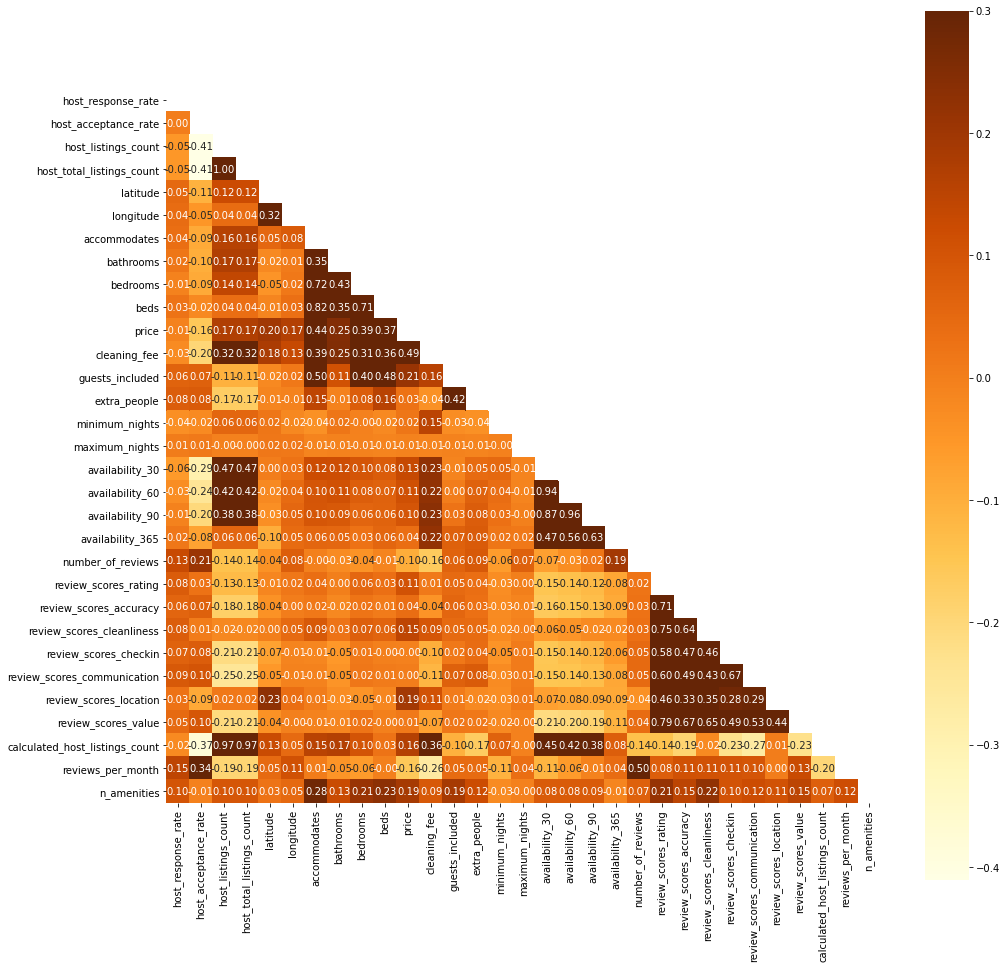

In [22]:
corrmat = listings[numeric_features].corr()

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(16,16))   
ax = sns.heatmap(corrmat, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f',cmap='YlOrBr')

### Boxplot

In [23]:
# Handling the outliers with the 1.5 x IQR rule: 220+((220-85)*1.5) = 422.5 in later stage
listings = listings[listings['price'] < 3000]
listings_plot = listings[listings['price'] < 422.5]
# The special prices considering 10$ or less have already been removed

<AxesSubplot:xlabel='beds', ylabel='price'>

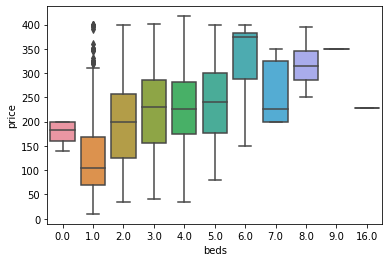

In [24]:
sns.boxplot(x='beds', y='price', data=listings_plot)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

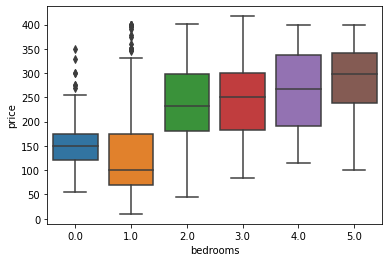

In [25]:
sns.boxplot(x='bedrooms', y='price', data=listings_plot)

<AxesSubplot:xlabel='room_type', ylabel='price'>

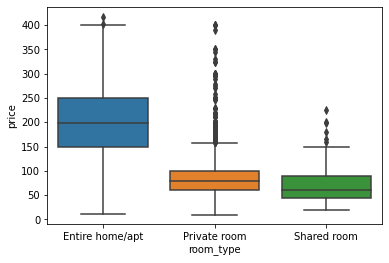

In [26]:
sns.boxplot(x='room_type', y='price', data=listings_plot)

In [27]:
neigh_cleansed = listings.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
neigh_cleansed

Index(['Leather District', 'South Boston Waterfront', 'Downtown', 'Chinatown',
       'Back Bay', 'Bay Village', 'West End', 'Beacon Hill', 'Fenway',
       'Charlestown', 'South End', 'North End', 'South Boston',
       'Jamaica Plain', 'Roxbury', 'East Boston', 'Brighton', 'Mission Hill',
       'West Roxbury', 'Allston', 'Longwood Medical Area', 'Roslindale',
       'Dorchester', 'Mattapan', 'Hyde Park'],
      dtype='object', name='neighbourhood_cleansed')

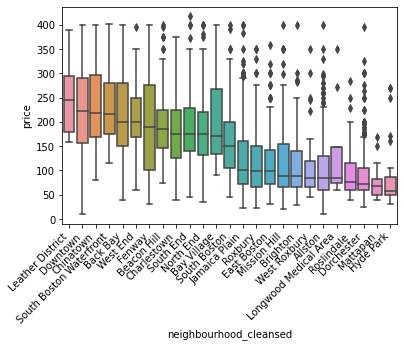

In [28]:
#listings = listings[listings['price'] > 10]
neigh_cleansed = listings_plot.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='neighbourhood_cleansed', order=neigh_cleansed, y='price', data=listings_plot)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

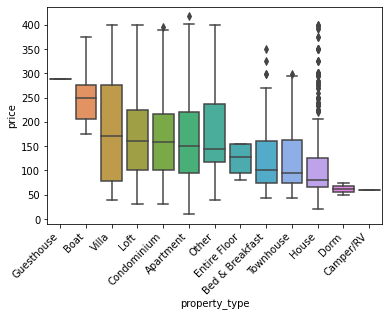

In [29]:
#check the property type
order_property_type = listings_plot.groupby('property_type')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='property_type', order=order_property_type, y='price', data=listings_plot)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [30]:
listings.price.describe()

count    3583.000000
mean      172.069216
std       125.277945
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      1400.000000
Name: price, dtype: float64

### Feature Engineering

In [31]:
#handling missing numeric values
listings = listings.fillna(listings.mean())

In [32]:
#Fill na with ffill/bfill since it is an object type and cannot be interpreted with numerical methods to fillna
listings['host_response_time'].fillna(method = 'backfill', inplace = True)

listings.host_response_time.isna().sum()

0

In [33]:
listings['property_type'].fillna(method = 'backfill', inplace = True)

listings.property_type.isna().sum()

0

### Target Engineering

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log_price'}>]], dtype=object)

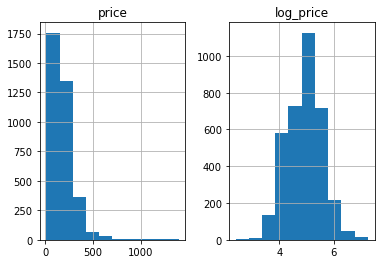

In [34]:
#since the price is right-skewed(positive skewness), we have to normalize the distribution
price = pd.DataFrame({'price': listings['price'], 'log_price': np.log1p(listings['price'])})
price.hist()

In [35]:
listings['log_price'] = np.log1p(listings['price'])

# Modelling

In [36]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression

In [37]:
listings.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,n_amenities,log_price
count,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3.583000e+03,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000
mean,94.989082,84.173089,58.934692,58.934692,42.340027,-71.084827,3.040748,1.221491,1.255807,1.608842,172.069216,68.380145,1.429807,10.878314,3.171086,2.874124e+04,8.650851,21.836729,38.562657,179.352777,19.055261,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,12.740441,1.970908,15.858498,4.947792
std,11.669462,20.303447,171.161957,171.161957,0.024409,0.031564,1.779282,0.500464,0.752103,1.010713,125.277945,42.657878,1.057015,19.131090,8.876410,1.670602e+06,10.436859,21.863489,33.159150,142.120171,35.578740,8.383496,0.818131,1.027234,0.670024,0.646324,0.793316,0.888032,29.421980,1.884203,4.830206,0.642513
min,0.000000,0.000000,0.000000,0.000000,42.235942,-71.171789,1.000000,0.000000,0.000000,0.000000,10.000000,5.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000,1.000000,2.397895
25%,94.989082,79.000000,1.000000,1.000000,42.329990,-71.105100,2.000000,1.000000,1.000000,1.000000,85.000000,40.000000,1.000000,0.000000,1.000000,3.650000e+02,0.000000,0.000000,0.000000,19.000000,1.000000,91.000000,9.000000,9.000000,9.646293,9.646549,9.000000,9.000000,1.000000,0.640000,13.000000,4.454347
50%,100.000000,91.000000,2.000000,2.000000,42.345192,-71.078429,2.000000,1.000000,1.000000,1.000000,150.000000,68.380145,1.000000,0.000000,2.000000,1.125000e+03,4.000000,16.000000,37.000000,179.000000,5.000000,92.000000,9.431571,9.258041,10.000000,10.000000,9.414043,9.168234,2.000000,1.910000,16.000000,5.017280
75%,100.000000,100.000000,7.000000,7.000000,42.354687,-71.062168,4.000000,1.000000,2.000000,2.000000,220.000000,80.000000,1.000000,20.000000,3.000000,1.125000e+03,15.000000,40.000000,68.500000,325.000000,21.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.130000,19.000000,5.398163
max,100.000000,100.000000,749.000000,749.000000,42.389982,-71.000100,16.000000,6.000000,5.000000,16.000000,1400.000000,300.000000,14.000000,200.000000,300.000000,1.000000e+08,30.000000,60.000000,90.000000,365.000000,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000,31.000000,7.244942


In [38]:
#finally let's put all relevant information together for the modeling
model_df = listings[['host_response_time', 'host_acceptance_rate'
                    , 'host_is_superhost'
                    , 'host_total_listings_count', 'accommodates', 'bathrooms'
                    , 'bedrooms', 'beds', 'price', 'cleaning_fee', 'guests_included'
                    #, 'availability_30', 'availability_60', 'availability_90', 'availability_365' 
                    , 'number_of_reviews', 'review_scores_rating'
                    , 'reviews_per_month'
                    , 'room_type'
                    #, 'neighbourhood_cleansed'
                    , 'cancellation_policy'
                    , 'property_type', 'n_amenities', 'log_price']]

In [39]:
#dataframe for natural language process to filter out words that might be relevant to customers
nlp_df = listings[['name', 'summary', 'description']]

In [40]:
model_df.dtypes

host_response_time            object
host_acceptance_rate         float64
host_is_superhost             object
host_total_listings_count      int64
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
price                          int64
cleaning_fee                 float64
guests_included                int64
number_of_reviews              int64
review_scores_rating         float64
reviews_per_month            float64
room_type                     object
cancellation_policy           object
property_type                 object
n_amenities                    int64
log_price                    float64
dtype: object

In [41]:
X = model_df.drop(['price', 'log_price'], axis=1)
y = model_df['log_price']

In [42]:
# ct = make_column_transformer(
#     (OneHotEncoder(), ['host_response_time'
#                        , 'host_is_superhost', 'room_type', 'neighbourhood_cleansed', 'cancellation_policy'
#                        , 'property_type']), remainder='passthrough')

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['host_response_time'
                        , 'host_is_superhost'
                        , 'room_type'
                        #, 'neighbourhood_cleansed'
                        , 'cancellation_policy'
                        , 'property_type'])], remainder='passthrough')

In [43]:
X = np.array(ct.fit_transform(X))

In [44]:
X[0]

array([ 0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        , 84.17308927,  1.        ,  4.        ,  1.5       ,
        2.        ,  3.        , 35.        ,  1.        ,  0.        ,
       91.91666667,  1.97090845, 15.        ])

In [45]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [46]:
X_train[0]

array([  0.        ,   0.        ,   0.        ,   1.        ,
         1.        ,   0.        ,   1.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   1.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  36.        , 307.        ,
         5.        ,   2.        ,   2.        ,   2.        ,
       199.        ,   1.        ,   0.        ,  91.91666667,
         1.97090845,  22.        ])

In [47]:
#Standardize the numerical features
sc = StandardScaler()
X_train[:, 26:] = sc.fit_transform(X_train[:, 26:])
X_test[:, 26:] = sc.transform(X_test[:, 26:])

In [48]:
X_train[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.38747628e+00,  1.48104476e+00,
        1.07744398e+00,  1.57730263e+00,  9.78942541e-01,  3.73947679e-01,
        3.05255483e+00, -4.08100939e-01, -5.35148767e-01, -1.41039190e-03,
        6.43557211e-03,  1.26298556e+00])

In [49]:
X_test[0]

array([ 0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.33308965, -0.03341921, -0.58096335, -0.4475218 ,
       -1.66670647, -0.59617731,  3.66202191, -0.40810094, -0.34092766,
       -0.69463504, -0.71637434, -1.22893111])

In [50]:
alphas = 10**np.linspace(-3,3,100)
from sklearn.metrics import mean_squared_error
ridge_cofficients = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha, normalize=True)
    ridge.fit(X_train, y_train)
    ridge_cofficients.append(ridge.coef_)

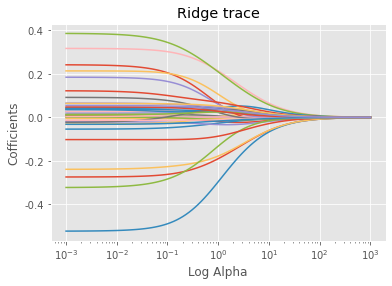

In [51]:
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
plt.plot(alphas, ridge_cofficients)
plt.xscale('log')
plt.axis('tight')
plt.title('Ridge trace')
plt.xlabel('Log Alpha')
plt.ylabel('Cofficients')
plt.show()    

In [52]:
# coss-validation test
ridge_cv = RidgeCV(alphas = alphas, normalize=True, cv = 10,scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)
# best lambda
ridge_cv.alpha_

0.04328761281083059

In [53]:
model_ridge=Ridge(alpha = ridge_cv.alpha_)
model_ridge.fit(X_train,y_train)
pred_ridge= model_ridge.predict(X_test)

# evaluate the result
rmse = np.sqrt(metrics.mean_squared_error(y_test,pred_ridge))
r_square = metrics.r2_score(y_test, pred_ridge)
print('For test data set our final result is:')
print('RMSE {}'.format(rmse ))
print('R^2 is {}'.format(r_square))

For test data set our final result is:
RMSE 0.44089913134086656
R^2 is 0.5482974729684795


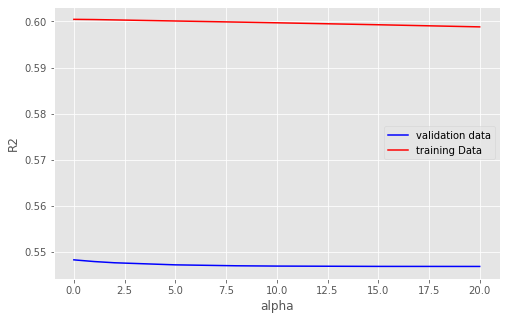

In [54]:
RR_square = []
RR_train = []
alpha = [0.0001, 0.001, 0.1, 1, 2,5,8,10, 15,20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RR_square.append(RigeModel.score(X_test, y_test))
    RR_train.append(RigeModel.score(X_train, y_train))
    
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RR_square,'b' ,label='validation data')
plt.plot(alpha,RR_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.legend();

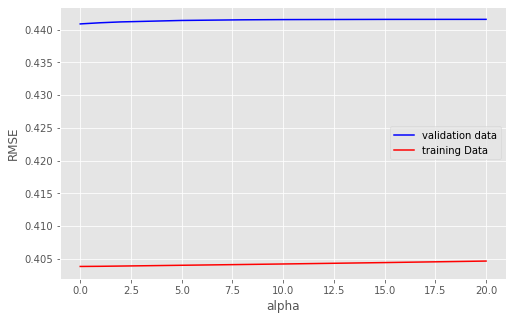

In [55]:
RMSE_valid = []
RMSE_train = []
alpha = [0.0001, 0.001, 0.1, 1, 2,5,8,10, 15,20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RMSE_valid.append(np.sqrt(mean_squared_error(y_test, RigeModel.predict(X_test))))
    RMSE_train.append(np.sqrt(mean_squared_error( y_train, RigeModel.predict(X_train))))    
    
    
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RMSE_valid,'b' ,label='validation data')
plt.plot(alpha,RMSE_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend();

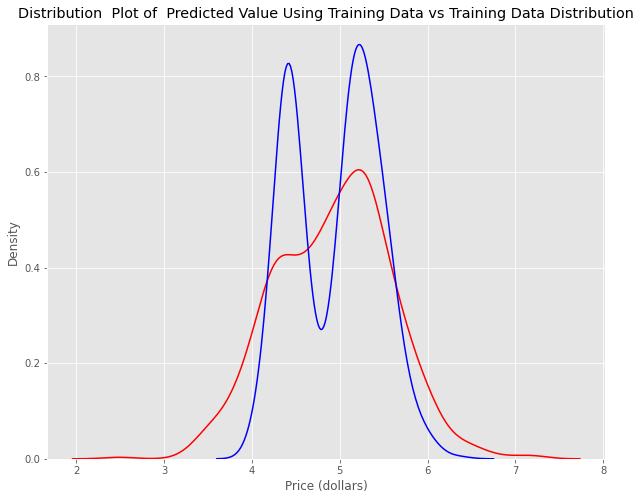

In [56]:
#Visualize model prediction
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    plt.figure(figsize=(10, 8))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()
DistributionPlot(y_test, pred_ridge, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

<AxesSubplot:xlabel='preds', ylabel='residuals'>

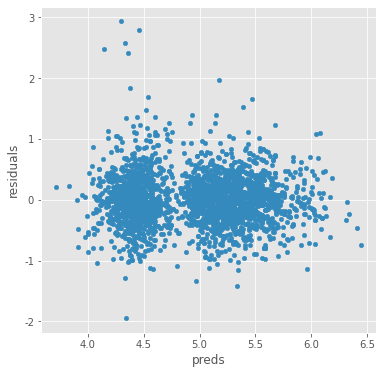

In [57]:
# residual scatter plot
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [58]:
np.corrcoef(model_ridge.predict(X_train),y_train)

array([[1.        , 0.77489497],
       [0.77489497, 1.        ]])

In [59]:
def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5))

In [60]:
#Model 1 Linear Regression
model_lr = LinearRegression()
rmse_cv(model_lr).mean()

4040576904.2303534